running estimation for lr=0.0 and step=1
running estimation for lr=0.2 and step=1
running estimation for lr=0.4 and step=1
running estimation for lr=0.6000000000000001 and step=1
running estimation for lr=0.8 and step=1
running estimation for lr=1.0 and step=1
running estimation for lr=0.0 and step=2
running estimation for lr=0.2 and step=2
running estimation for lr=0.4 and step=2
running estimation for lr=0.6000000000000001 and step=2
running estimation for lr=0.8 and step=2
running estimation for lr=1.0 and step=2
running estimation for lr=0.0 and step=4
running estimation for lr=0.2 and step=4
running estimation for lr=0.4 and step=4
running estimation for lr=0.6000000000000001 and step=4
running estimation for lr=0.8 and step=4
running estimation for lr=1.0 and step=4
running estimation for lr=0.0 and step=8
running estimation for lr=0.2 and step=8
running estimation for lr=0.4 and step=8
running estimation for lr=0.6000000000000001 and step=8
running estimation for lr=0.8 and step

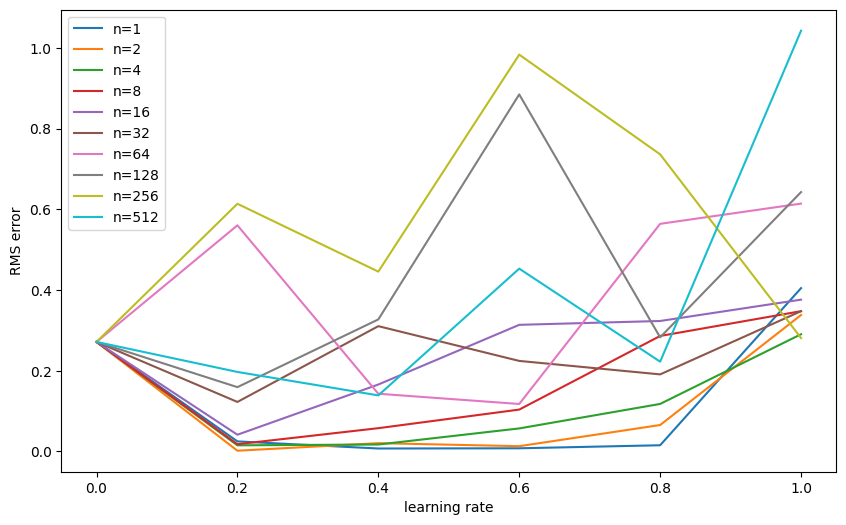

In [1]:
import numpy as np

# 19 states (not including the ending state)
NUM_STATES = 19
START = 9
END_0 = 0
END_1 = 20


class RandomWalk:

    def __init__(self, n, start=START, end=False, lr=0.1, gamma=1, debug=False):
        self.actions = ["left", "right"]
        self.state = start  # current state
        self.end = end
        self.n = n
        self.lr = lr
        self.gamma = gamma
        self.debug = debug
        # init q estimates
        self.Q_values = {}
        for i in range(NUM_STATES + 2):
            self.Q_values[i] = {}
            for a in self.actions:
                if i in [END_0, END_1]:
                    # explicitly set end state values
                    if i == END_0:
                        self.Q_values[i][a] = -1
                    else:
                        self.Q_values[i][a] = 1
                else:
                    self.Q_values[i][a] = 0

    def chooseAction(self):
        action = np.random.choice(self.actions)
        return action

    def takeAction(self, action):
        new_state = self.state
        if not self.end:
            if action == "left":
                new_state = self.state - 1
            else:
                new_state = self.state + 1

            if new_state in [END_0, END_1]:
                self.end = True
        self.state = new_state
        return self.state

    def giveReward(self):
        if self.state == END_0:
            return -1
        if self.state == END_1:
            return 1
        # other states
        return 0

    def reset(self):
        self.state = START
        self.end = False

    def play(self, rounds=100):
        for _ in range(rounds):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction()

            actions = [action]
            states = [self.state]
            rewards = [0]
            while True:
                if t < T:
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward

                    states.append(state)
                    rewards.append(reward)

                    if self.end:
                        if self.debug:
                            print("End at state {} | number of states {}".format(state, len(states)))
                        T = t + 1
                    else:
                        action = self.chooseAction()
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau + 1, min(tau + self.n + 1, T + 1)):
                        G += np.power(self.gamma, i - tau - 1) * rewards[i]
                    if tau + self.n < T:
                        state_action = (states[tau + self.n], actions[tau + self.n])
                        G += np.power(self.gamma, self.n) * self.Q_values[state_action[0]][state_action[1]]
                    # update Q values
                    state_action = (states[tau], actions[tau])
                    self.Q_values[state_action[0]][state_action[1]] += self.lr * (
                                G - self.Q_values[state_action[0]][state_action[1]])

                if tau == T - 1:
                    break

                t += 1


if __name__ == "__main__":

    actual_state_values = np.arange(-20, 22, 2) / 20.0

    lr_range = np.linspace(0, 1, 6)
    n_range = np.power(2, range(10))
    episodes = 100

    sq_errors = {}

    for n in n_range:
        ers = []
        for lr in lr_range:
            print("running estimation for lr={} and step={}".format(lr, n))
            rw = RandomWalk(n=n, lr=lr, debug=False)
            rw.play(episodes)
            # V(s) = 0.5*Q(S, 'left') + 0.5*Q(S, 'right')
            estimate_state_values = [np.mean(list(v.values())) for v in rw.Q_values.values()]

            ers.append(np.mean([er ** 2 for er in actual_state_values - np.array(estimate_state_values)]))
        sq_errors[n] = ers

    # visualisation
    import matplotlib.pyplot as plt

    plt.figure(figsize=[10, 6])

    for n in n_range:
        plt.plot(lr_range, sq_errors[n], label="n={}".format(n))

    plt.xlabel('learning rate')
    plt.ylabel('RMS error')
    plt.legend()
    plt.show()